In [1]:
import os
import pandas as pd
import numpy as np
import glob

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_formatrmat = 'retina'

In [2]:
from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data_sulfur
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data_sulfur
from stesml.data_tools import get_test_data_sulfur

from stesml.model_tools import get_model
from stesml.model_tools import walk_forward_validation
from stesml.model_tools import get_predictions
from stesml.model_tools import get_progress

from stesml.postprocessing_tools import get_h

from stesml.plot_tools import get_plot_data
from stesml.plot_tools import plot_test_results_sulfur
from stesml.plot_tools import plot_average_error_sulfur
from stesml.plot_tools import plot_error_vs_T
from stesml.plot_tools import plot_progress_results

/Users/kmenear/Projects/envSulfurTES/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data_dir = "../data/Sulfur_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [14]:
model_type = "XGBoost"
is_recurrent = False
n_estimators = 100
target = 'T'

In [24]:
from typing import Tuple

def relu(x):
    return max(x,0)

def focal_obj(X_train):
    def custom_obj(y: np.ndarray, y_hat: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        rows = y.shape[0]
        zeros = np.zeros((rows), dtype=float)
        ones = np.ones((rows), dtype=float)
        grad = np.zeros((rows), dtype=float)
        hess = np.zeros((rows), dtype=float)
        Tw = X_train[:,1]
        Ti = X_train[:,2]
        # (y_hat - y)^2 + relu(Ti-y_hat) + relu(y_hat - Tw)
        grad = 4*(y_hat - y) - 0*np.maximum((Ti - y_hat),zeros) + 0*np.maximum((y_hat - Tw),zeros)
        hess = 4*ones + 0*np.maximum(np.sign(Ti - y_hat),zeros) + 0*np.maximum(np.sign(y_hat - Tw),zeros)
        grad = grad.reshape((rows, 1))
        hess = hess.reshape((rows, 1))
        return grad, hess
    return custom_obj

In [29]:
train_index, test_index = get_train_and_test_index(scenario_index)

X_train, y_train = get_train_data_sulfur(scenario_index, train_index, is_recurrent, target=target)
X_test, y_test = get_test_data_sulfur(scenario_index, test_index, is_recurrent, target=target)

In [30]:
model = get_model(model_type, n_estimators)

In [15]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=n_estimators, colsample_bylevel=.75, objective=focal_obj(X_train))

NameError: name 'focal_obj' is not defined

In [31]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [32]:
y_hat = get_predictions(model, X_test, is_recurrent)

In [33]:
print(r2_score(y_test, y_hat))

0.9559690277696979


In [34]:
print(mean_squared_error(y_test, y_hat, squared=False))

6.214054788854533


In [12]:
test_df = load_data(scenario_index, test_index, is_recurrent_test_data=True)
h = get_h(test_df[5])

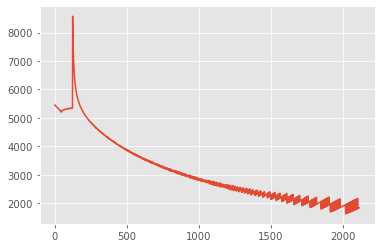

In [13]:
import matplotlib.pyplot as plt
window = 25
average_h = []
for ind in range(len(h) - window + 1):
    average_h.append(np.mean(h[ind:ind+window]))
    
plt.plot(h)

In [35]:
test_df = load_data_sulfur(scenario_index, test_index)
test_df_plot = get_plot_data(y_hat, test_df, test_index, is_recurrent)

ValueError: x and y must have same first dimension, but have shapes (72027,) and (74097,)

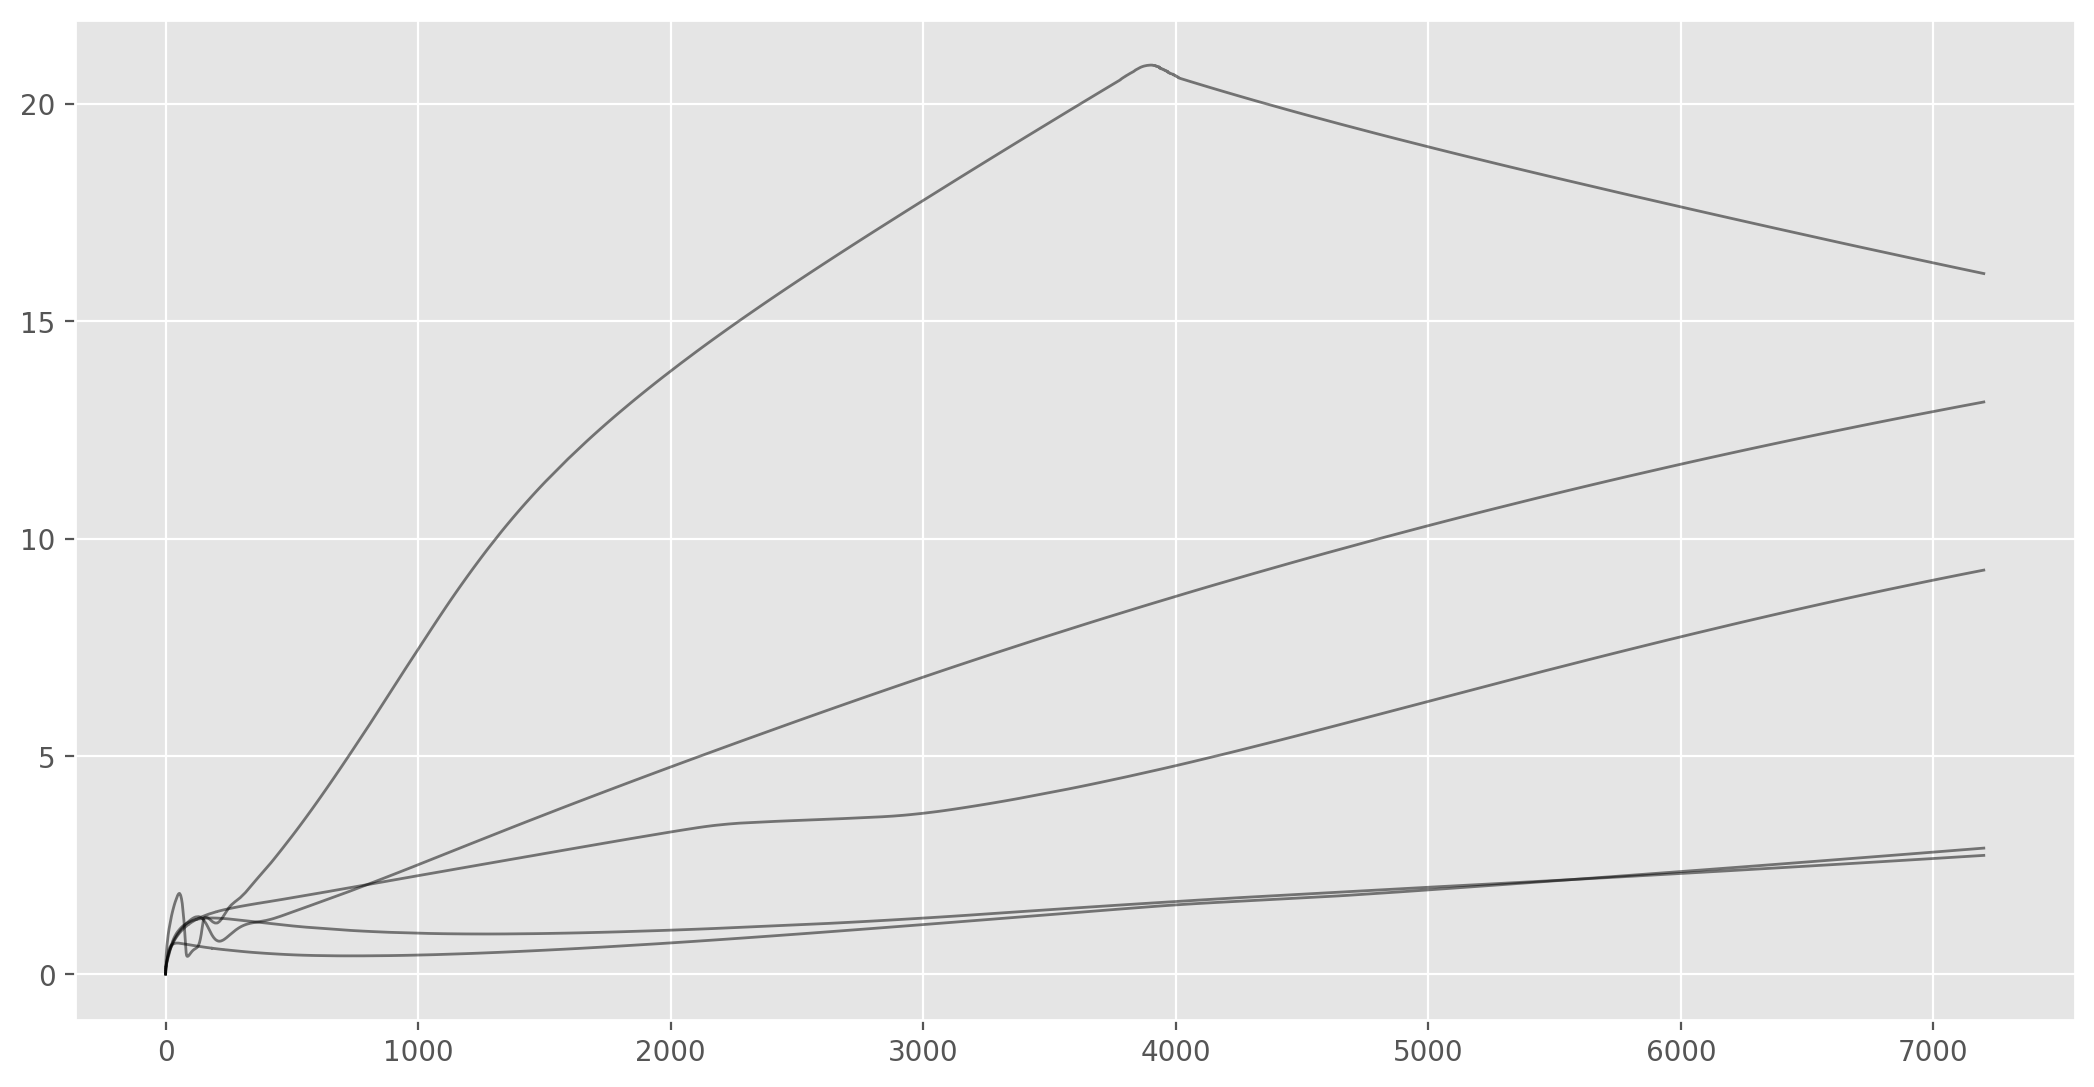

In [17]:
plot_average_error_sulfur(test_df_plot)

<AxesSubplot:>

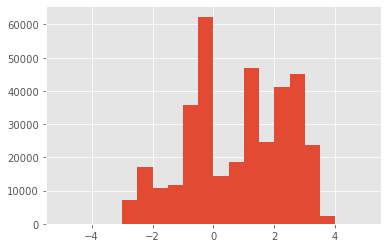

In [20]:
(100*(test_df_plot["Tavg"] - test_df_plot["Tc_hat"])/test_df_plot["Tavg"]).hist(bins=20, range=(-5, 5))

<AxesSubplot:>

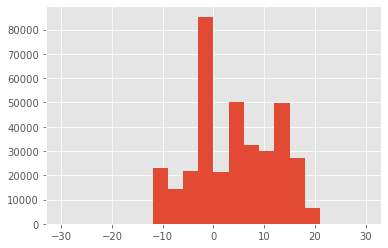

In [21]:
(test_df_plot["Tavg"] - test_df_plot["Tc_hat"]).hist(bins=20, range=(-30, 30))

In [22]:
plot_error_vs_T(test_df_plot)

KeyError: 'Tc'

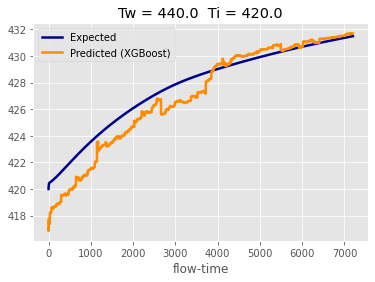

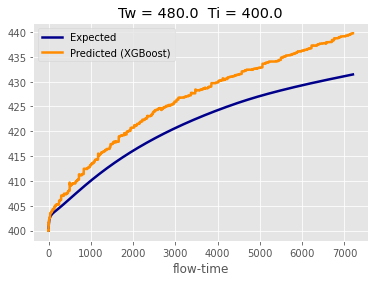

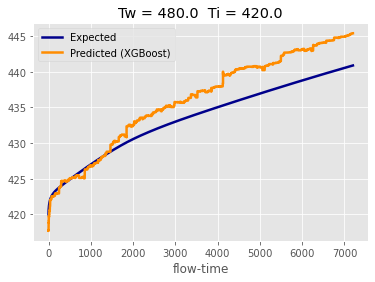

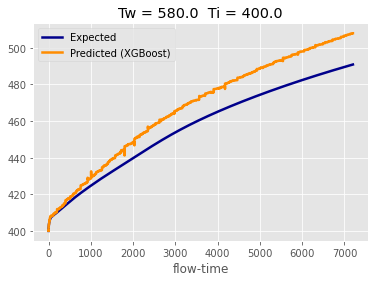

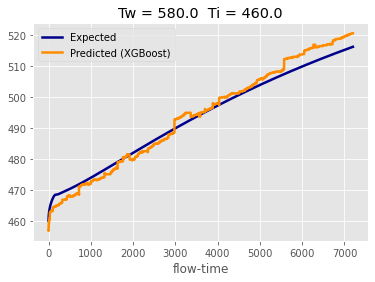

In [36]:
plot_test_results_sulfur(test_df_plot, model_type, target=target)

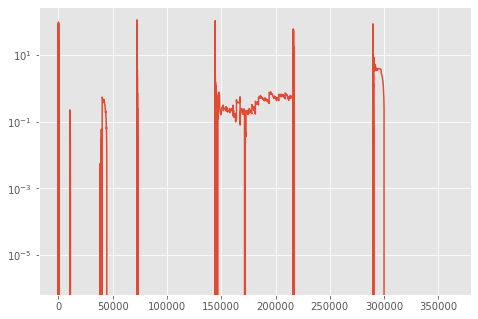

In [19]:
import matplotlib.pyplot as plt
ax = plt.figure().add_axes([0,0,1,1])
ax.plot(y_test-y_hat)
ax.set_yscale('log')
plt.show()

In [34]:
min_estimators = 10
max_estimators = 11
step_size = 2
num_shuffle_iterations = 50

rmse_history, r2_history = get_progress(model_type, scenario_index, min_estimators, max_estimators, step_size, num_shuffle_iterations, is_recurrent, verbose=True, target=target)

0
Predicted: [   0.         4376.7662209  4384.32949672 ...   29.32619196   29.326108
   29.3260854 ]
Expected: [   0.         4487.55693828 4480.49257033 ...   26.4223336    26.42225858
   26.42223849]
1
Predicted: [   0.         3668.84112766 3664.43995103 ...   19.72203728   19.72201794
   19.72201794]
Expected: [   0.         3668.86628447 3664.38943667 ...   24.77357315   24.77351687
   24.77351123]
2
Predicted: [   0.         3668.8994838  3664.43860515 ...   29.86933065   29.86926236
   29.86923305]
Expected: [   0.         3669.11455896 3664.89090661 ...   29.32619196   29.32611123
   29.32607356]
3
Predicted: [   0.         4391.8565968  4389.98061447 ...   19.72210226   19.72202664
   19.72199214]
Expected: [   0.         4487.55693828 4480.49257033 ...   25.05571994   25.0555973
   25.05548041]
4
Predicted: [   0.         4421.24582653 4418.63565195 ...   29.86930918   29.86929358
   29.86927012]
Expected: [   0.         4487.55693828 4480.49257033 ...   29.32619196   29.326

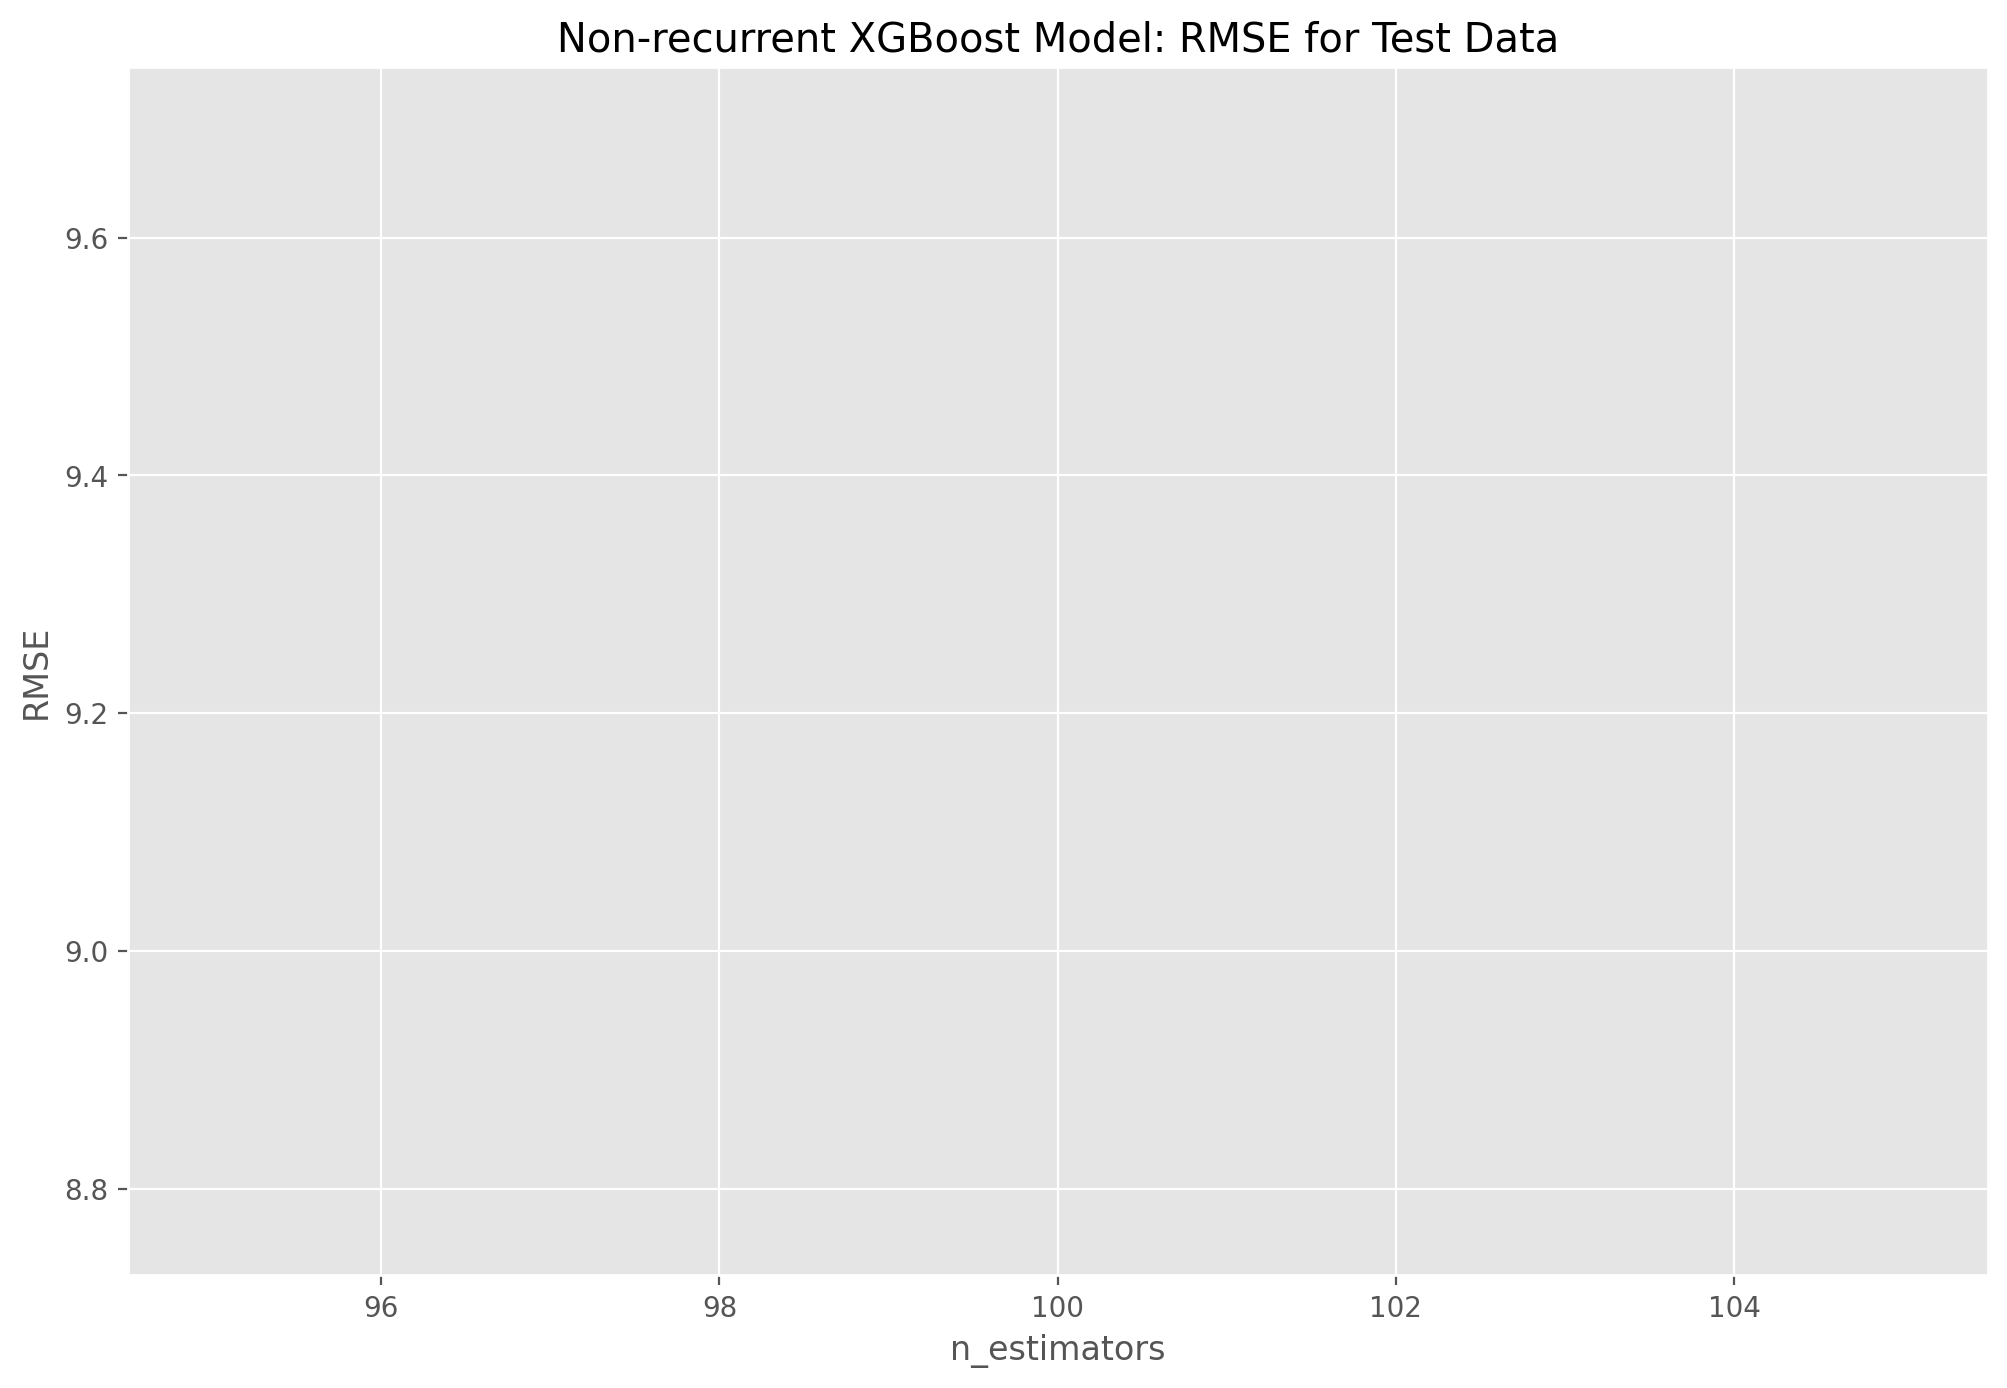

In [6]:
plot_progress_results(rmse_history, model_type, is_recurrent, metric="RMSE")

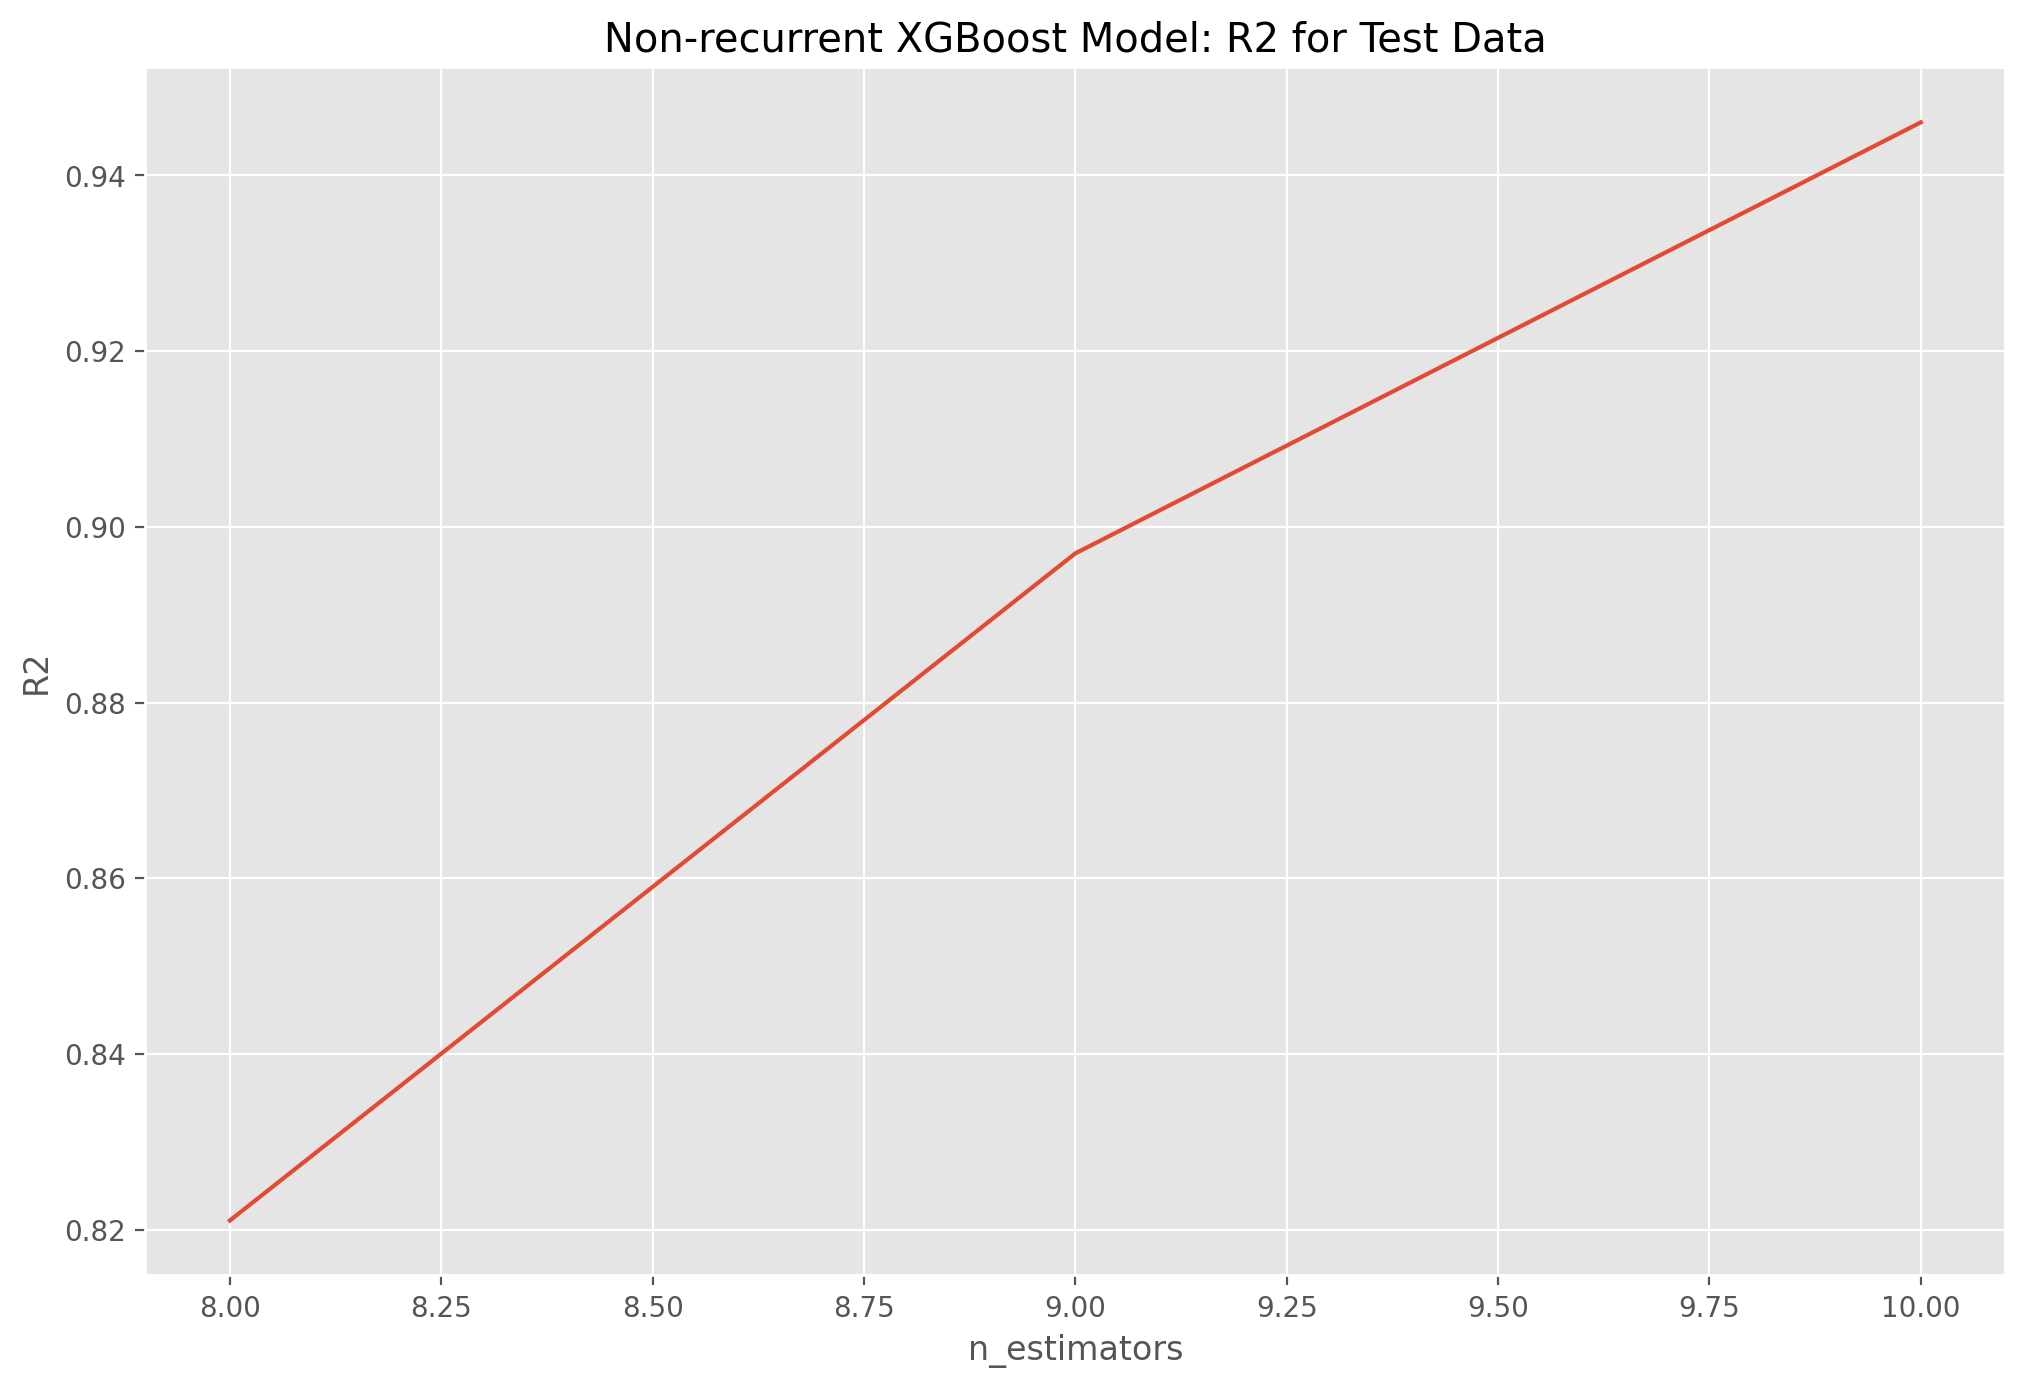

In [22]:
plot_progress_results(r2_history, model_type, is_recurrent, metric="R2")